<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Map Resources and Topography
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/map_resources_preview.png" alt="Colorized topography overlay with several geographic map boundaries" style="height: 300px;"></div>


# Objectives

* Use python-awips to connect to an edex server
* Define data request object specifically for the maps database
* Manipulate request object for various different map resources
* Plot map resources in combination with one another for geographical context

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Connect-to-EDEX" data-toc-modified-id="Connect-to-EDEX-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Connect to EDEX</a></span></li><li><span><a href="#Function:-make_map()" data-toc-modified-id="Function:-make_map()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function: make_map()</a></span></li><li><span><a href="#Create-Initial-Map-From-CWA" data-toc-modified-id="Create-Initial-Map-From-CWA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create Initial Map From CWA</a></span></li><li><span><a href="#Draw-Merged-CWA" data-toc-modified-id="Draw-Merged-CWA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Draw Merged CWA</a></span></li><li><span><a href="#Draw-Interstates-using-Boundary-Filter" data-toc-modified-id="Draw-Interstates-using-Boundary-Filter-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Draw Interstates using Boundary Filter</a></span></li><li><span><a href="#Draw-Nearby-Cities" data-toc-modified-id="Draw-Nearby-Cities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Draw Nearby Cities</a></span></li><li><span><a href="#Draw-Nearby-Lakes" data-toc-modified-id="Draw-Nearby-Lakes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Draw Nearby Lakes</a></span></li><li><span><a href="#Draw-Major-Rivers" data-toc-modified-id="Draw-Major-Rivers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Draw Major Rivers</a></span></li><li><span><a href="#Draw-Topography" data-toc-modified-id="Draw-Topography-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Draw Topography</a></span></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [17]:
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy.ma as ma
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.ops import unary_union

<a href="#top">Top</a>

---

## Connect to EDEX

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***maps***.

In [18]:
# Server, Data Request Type, and Database Table
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps')

<a href="#top">Top</a>

---

## Function: make_map()

In many of our notebooks we end up plotting map images, and this logic below is the same from those other notebooks.  Typically, functions are defined when they are called multiple times throughout a notebook.  In this case, we only use it in one code block cell, but because it is a common function from several of our notebooks, it's nice to keep the logic neatly defined for consistency.

In [19]:
# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

<a href="#top">Top</a>

---

## Create Initial Map From CWA

The python-awips package provides access to the entire AWIPS Maps Database for use in Python GIS applications.  Map objects are returned as <a href="http://toblerity.org/shapely/manual.html">Shapely</a> geometries and can be easily plotted by many Python packages.

* Each map database table has a geometry field called `the_geom`, which can be used to spatially select map resources for any column of type geometry.

<br>
<div class="alert-info">
    <b>Tip:</b>  Note the geometry definition of <code>the_geom</code> for each data type, which can be <b>Point</b>, <b>MultiPolygon</b>, or <b>MultiLineString</b>.
</div>
<br>

Here we'll be using Boulder (BOU) as our example for plotting the County Warning Area (CWA).  We'll query our EDEX server to get all counties in the CWA for BOU, and then plot those counties along withe the state boundaries and lines of longitude and latitude.  In order to get this information from EDEX, we'll need to set several characteristics on our data request object.  We will use [**request.setParameters()**](http://unidata.github.io/python-awips/api/IDataRequest.html#awips.dataaccess.IDataRequest.setParameters) to refine our query to EDEX.

Using 22 county MultiPolygons


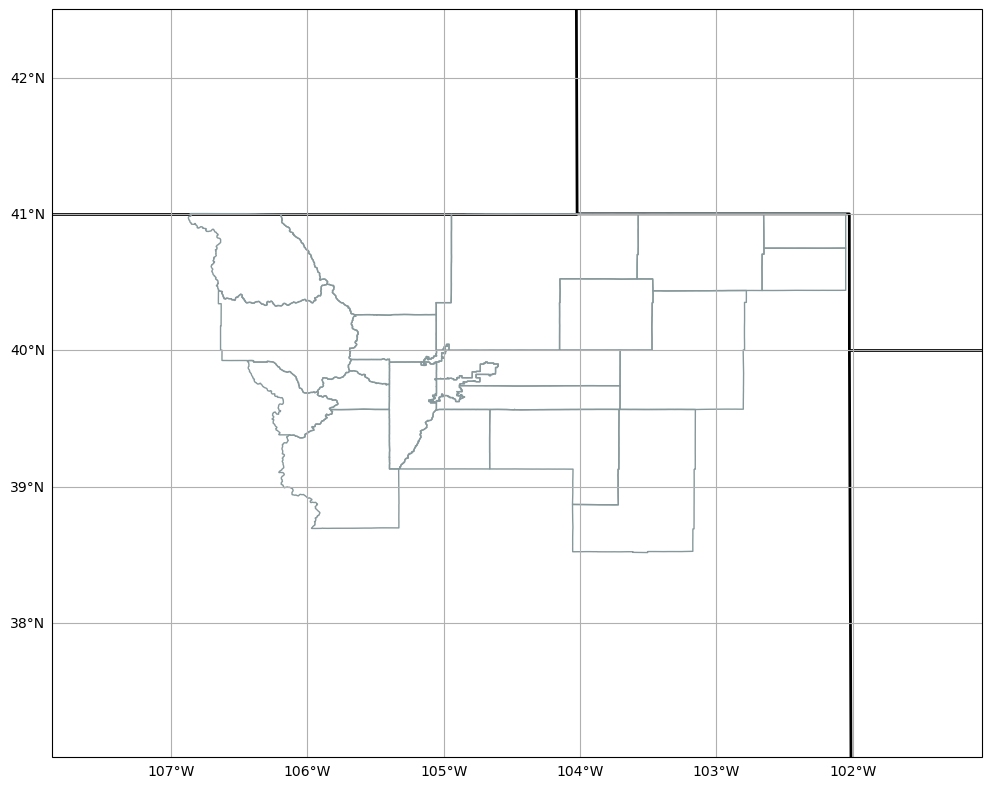

In [20]:
# Specify the necessary identifiers for requesting the Boulder CWA
request.addIdentifier('table', 'mapdata.county')
# Define a WFO ID for location
# tie this ID to the mapdata.county column "cwa" for filtering
request.setLocationNames('BOU')
request.addIdentifier('cwa', 'BOU')
# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')

# Get response and create dict of county geometries
response = DataAccessLayer.getGeometryData(request)
counties = []
for ob in response:
    counties.append(ob.getGeometry())
print("Using " + str(len(counties)) + " county MultiPolygons")


# All WFO counties merged to a single Polygon
merged_counties = unary_union(counties)
envelope = merged_counties.buffer(2)
boundaries=[merged_counties]

# Get bounds of this merged Polygon to use as buffered map extent
bounds = merged_counties.bounds
bbox=[bounds[0]-1,bounds[2]+1,bounds[1]-1.5,bounds[3]+1.5]

# Create the map we'll use for the rest of this notebook based on the 
# boundaries of the CWA
fig, ax = make_map(bbox=bbox)

# Plot political/state boundaries handled by Cartopy
political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

# Plot CWA counties
shape_feature = ShapelyFeature(counties,ccrs.PlateCarree(), 
                    facecolor='none', linestyle="-",edgecolor='#86989B')
ax.add_feature(shape_feature)

<a href="#top">Top</a>

---

## Draw Merged CWA

In the previous section we created a merged polygon with the applicable counties. Here, we draw this new shape on top of our existing map in a burnt orange color.

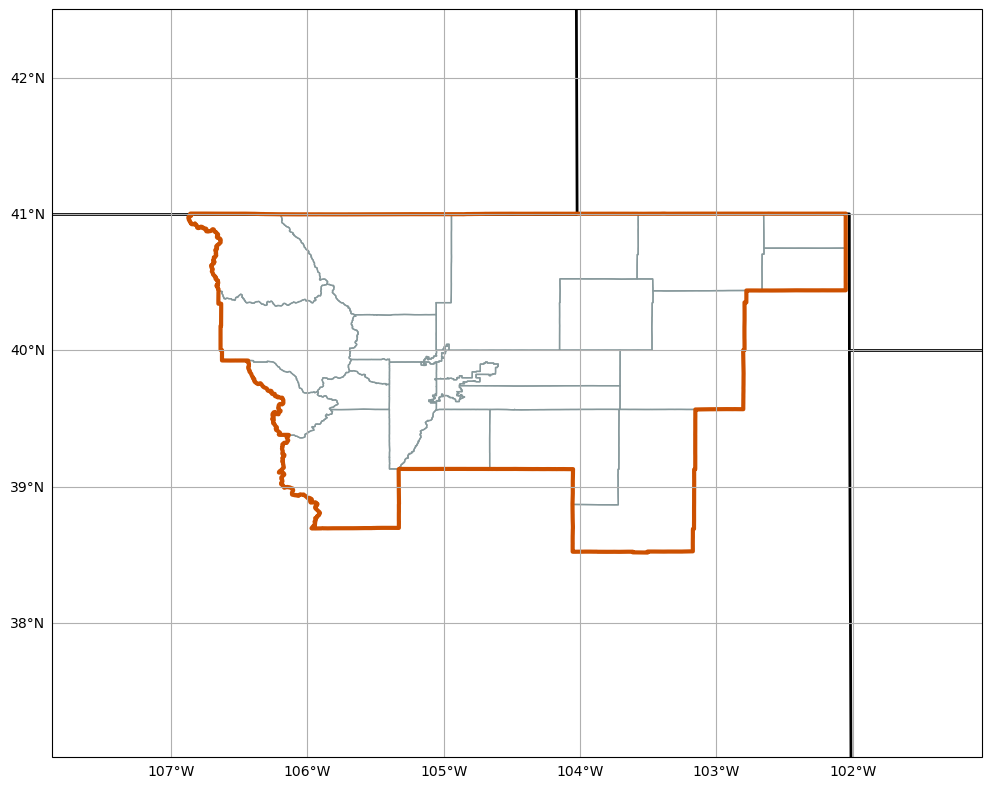

In [21]:
# Plot CWA envelope
shape_feature = ShapelyFeature(boundaries,ccrs.PlateCarree(), 
                    facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
ax.add_feature(shape_feature)

fig

<a href="#top">Top</a>

---

## Draw Interstates using Boundary Filter

Now, we'll use the previously-defined **envelope=merged_counties.buffer(2)** in a **newDataRequest()** to request interstate geometries which fall inside the buffered boundary. 

Using 225 interstate MultiLineStrings


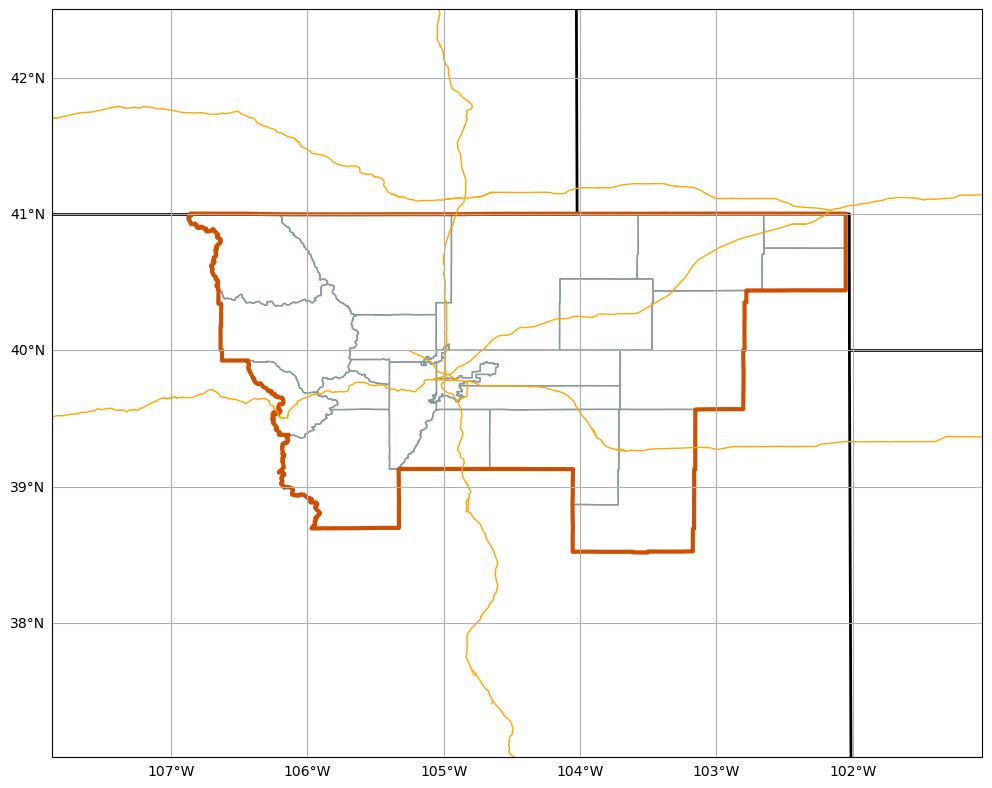

In [22]:
# Define the request for the interstate query
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.interstate')
request.addIdentifier('geomField', 'the_geom')
interstates = DataAccessLayer.getGeometryData(request)
print("Using " + str(len(interstates)) + " interstate MultiLineStrings")

# Plot interstates
for ob in interstates:
    shape_feature = ShapelyFeature(ob.getGeometry(),ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='orange')
    ax.add_feature(shape_feature)
fig

<a href="#top">Top</a>

---

## Draw Nearby Cities

Request the city table based using the **envelope** attribute and filter by population and progressive disclosure level.

<br>
<div class="alert-warning">
    <b>Warning:</b>  the <code>prog_disc</code> field is not entirely understood and values appear to change significantly depending on WFO site.
</div>

Queried 1181 total cities
Plotting 51 cities


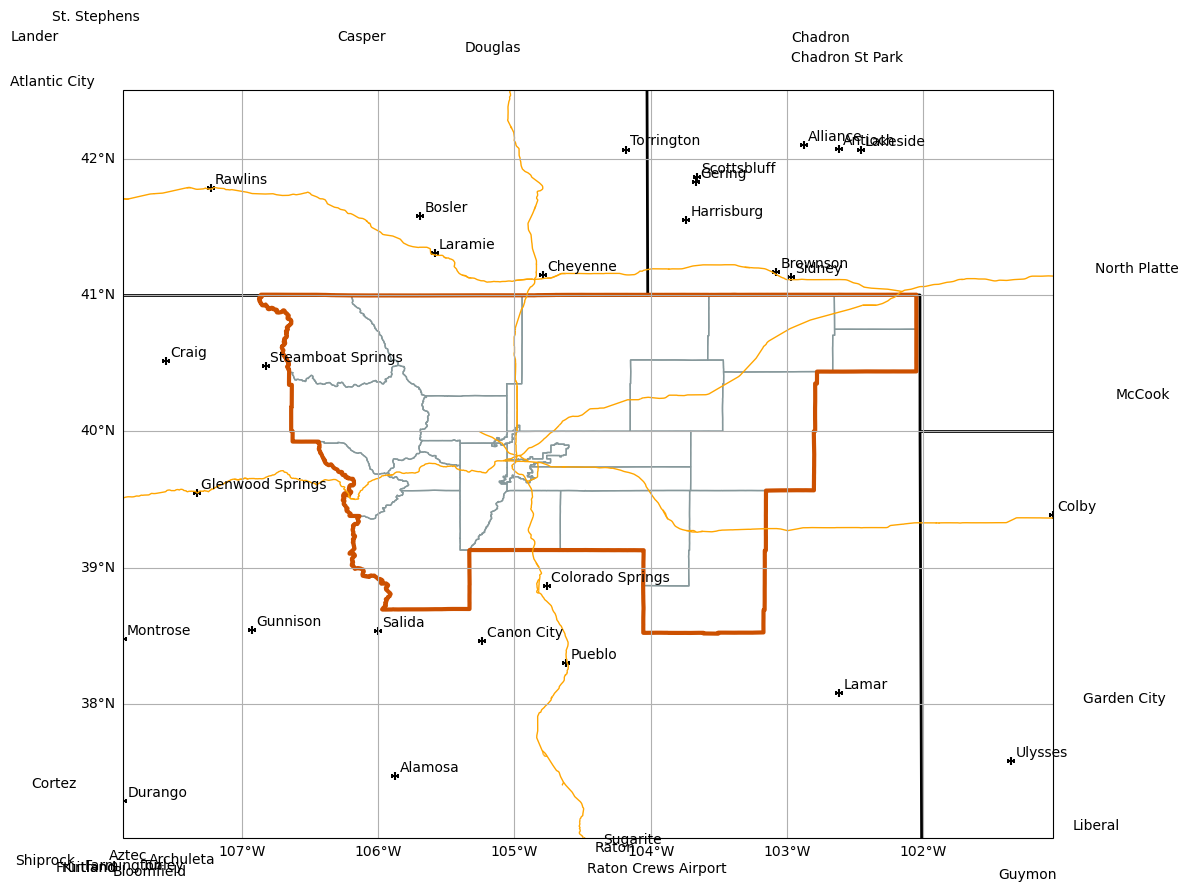

In [23]:
# Define the request for the city query
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.city')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('name','population','prog_disc')
cities = DataAccessLayer.getGeometryData(request)
print("Queried " + str(len(cities)) + " total cities")

# Set aside two arrays - one for the geometry of the cities and one for their names
citylist = []
cityname = []
# For BOU, progressive disclosure values above 50 and pop above 5000 looks good
for ob in cities:
    if ob.getString("population") != 'None':
        if ob.getNumber("prog_disc") > 50 and int(ob.getString("population")) > 5000:
            citylist.append(ob.getGeometry())
            cityname.append(ob.getString("name"))
print("Plotting " + str(len(cityname)) + " cities")

# Plot city markers
ax.scatter([point.x for point in citylist],
       [point.y for point in citylist],
       transform=ccrs.PlateCarree(),marker="+",facecolor='black')
# Plot city names
for i, txt in enumerate(cityname):
    ax.annotate(txt, (citylist[i].x,citylist[i].y),
                xytext=(3,3), textcoords="offset points")

fig

<a href="#top">Top</a>

---

## Draw Nearby Lakes

Again, use the **envelope** attribute to define a new data requst for the nearby lakes.

Using 208 lake MultiPolygons


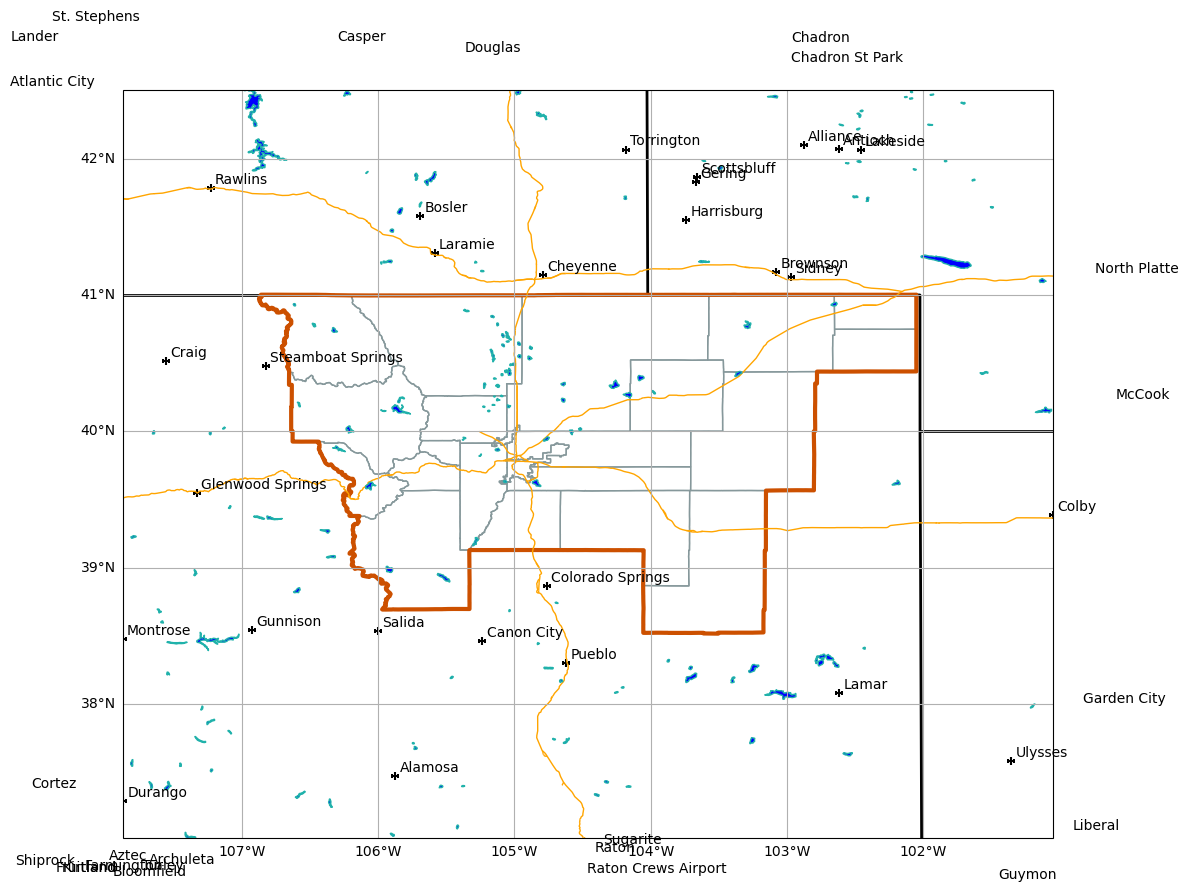

In [24]:
# Define request for lakes
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.lake')
request.addIdentifier('geomField', 'the_geom')

# Get lake geometries
response = DataAccessLayer.getGeometryData(request)
print("Using " + str(len(response)) + " lake MultiPolygons")

# Plot lakes
shape_feature = ShapelyFeature([lake.getGeometry() for lake in response],ccrs.PlateCarree(), 
                    facecolor='blue', linestyle="-",edgecolor='#20B2AA')
ax.add_feature(shape_feature)
fig


<a href="#top">Top</a>

---

## Draw Major Rivers

Using 1400 river MultiLineStrings


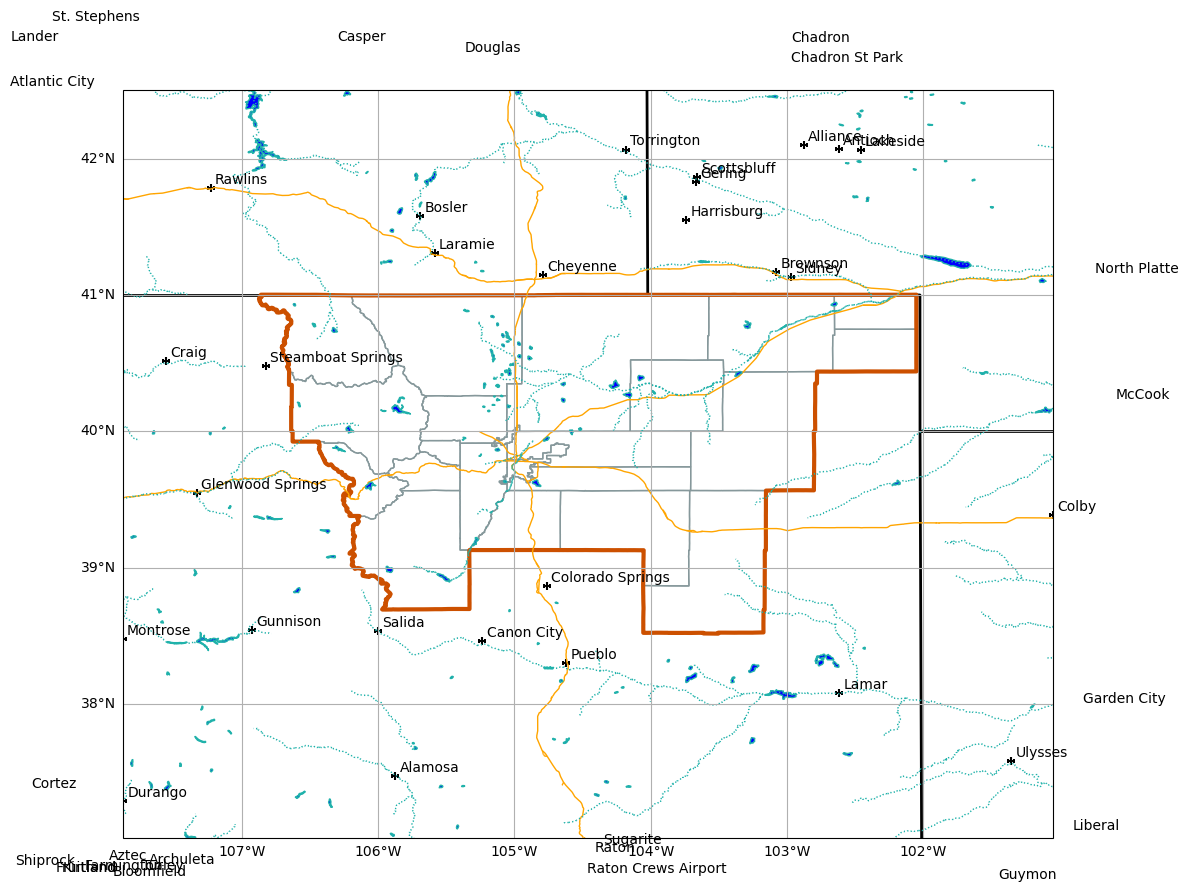

In [25]:
# Define request for rivers
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.majorrivers')
request.addIdentifier('geomField', 'the_geom')
rivers = DataAccessLayer.getGeometryData(request)
print("Using " + str(len(rivers)) + " river MultiLineStrings")

# Plot rivers
shape_feature = ShapelyFeature([river.getGeometry() for river in rivers],ccrs.PlateCarree(), 
                    facecolor='none', linestyle=":",edgecolor='#20B2AA')
ax.add_feature(shape_feature)
fig

<a href="#top">Top</a>

---

## Draw Topography

Spatial envelopes are required for topo requests, which can become slow to download and render for large (CONUS) maps.

In [26]:
# Define topography request
request = DataAccessLayer.newDataRequest("topo", envelope=envelope)
request.addIdentifier("group", "/")
request.addIdentifier("dataset", "full")
gridData = DataAccessLayer.getGridData(request)
print(gridData)
print("Number of grid records: " + str(len(gridData)))
print("Sample grid data shape:\n" + str(gridData[0].getRawData().shape) + "\n")
print("Sample grid data:\n" + str(gridData[0].getRawData()) + "\n")

Number of grid records: 1
Sample grid data shape:
(778, 1058)

Sample grid data:
[[1694. 1693. 1688. ...  757.  761.  762.]
 [1701. 1701. 1701. ...  758.  760.  762.]
 [1703. 1703. 1703. ...  760.  761.  762.]
 ...
 [1767. 1741. 1706. ...  769.  762.  768.]
 [1767. 1746. 1716. ...  775.  765.  761.]
 [1781. 1753. 1730. ...  766.  762.  759.]]



623.0
4328.0


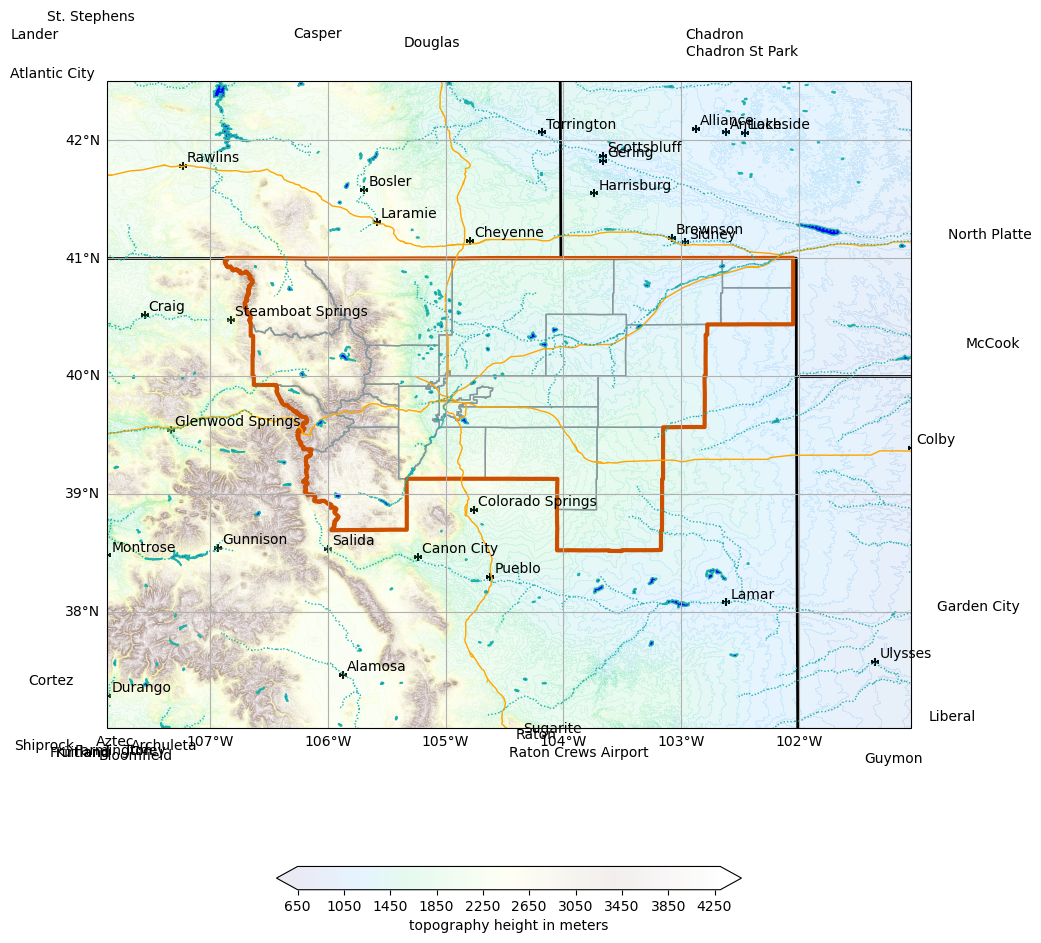

In [27]:
grid=gridData[0]
topo=ma.masked_invalid(grid.getRawData()) 
lons, lats = grid.getLatLonCoords()
print(topo.min()) # minimum elevation in our domain (meters)
print(topo.max()) # maximum elevation in our domain (meters)

# Plot topography
cs = ax.contourf(lons, lats, topo, 80, cmap=plt.get_cmap('terrain'),alpha=0.1, extend='both')
cbar = fig.colorbar(cs, shrink=0.5, orientation='horizontal')
cbar.set_label("topography height in meters")

fig

<a href="#top">Top</a>

---

## See Also

### Additional Documentation

* This notebook requires: **python-awips, numpy, matplotplib, cartopy, shapely**
* Use datatype **maps** and **addIdentifier('table', &lt;postgres maps schema&gt;)** to define the map table:
        DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
        request = DataAccessLayer.newDataRequest('maps')
        request.addIdentifier('table', 'mapdata.county')
* Use **request.setLocationNames()** and **request.addIdentifier()** to spatially filter a map resource. In the example below, WFO ID **BOU** (Boulder, Colorado) is used to query counties within the BOU county watch area (CWA) 
    
        request.addIdentifier('geomField', 'the_geom')
        request.addIdentifier('inLocation', 'true')
        request.addIdentifier('locationField', 'cwa')
        request.setLocationNames('BOU')
        request.addIdentifier('cwa', 'BOU')
        
See the <a href="http://unidata.github.io/awips2/python/maps-database/#mapdatacwa">Maps Database Reference Page</a> for available database tables, column names, and types. 

<a href="#top">Top</a>

---